In [ ]:
!nvidia-smi

Wed Jan 27 06:33:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# importing the required libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
import numpy as np
import matplotlib.pyplot as plt  

In [ ]:
# defining the dataset path

train_path = '/content/drive/MyDrive/Malaria Disease classification/data/Train'
valid_path = '/content/drive/MyDrive/Malaria Disease classification/data/Test'

In [ ]:
# resizing the input image for VGG19 requirements

image_size = [224, 224]

In [ ]:
# importing VGG19 architecture and using imagenet pretrained weights

v19 = VGG19(include_top=False, weights='imagenet', input_shape=image_size + [3])

In [ ]:
# checking the architecture

v19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# freezing the VGG19 pretrained weights

for layer in v19.layers:
  layer.trainable = False

In [ ]:
# getting the number of output classes

folders = glob('/content/drive/MyDrive/Malaria Disease classification/data/Train/*')

folders

['/content/drive/MyDrive/Malaria Disease classification/data/Train/Parasite',
 '/content/drive/MyDrive/Malaria Disease classification/data/Train/Uninfected']

In [ ]:
# number of classes

len(folders)

2

In [ ]:
# flattening after the last layer of vgg19 (MaxPooling2D)(None, 7, 7, 512) )

x = Flatten()(v19.output)

x

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [ ]:
# creating FC/Dense layers after flattening. we can have multiple of this layer

fc = Dense(units=len(folders), activation='softmax')(x)

In [ ]:
print(fc)
print(v19.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
# creating the whole model: VGG19 + own layers

model = Model(inputs=v19.input, outputs=fc)

In [ ]:
# checking the whole architecture

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# defining model performance metrics

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# using ImageDataGenerator for data augmentation and importing images from dataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# providing target size the same as the initial size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria Disease classification/data/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [ ]:
# same for test set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Malaria Disease classification/data/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [ ]:
# fitting the model

fitted_model = model.fit(training_set,
                          validation_data = test_set,
                          epochs = 50,
                          steps_per_epoch = len(training_set),
                          validation_steps = len(test_set))

Epoch 1/50
13/13 [==============================] - 8s 423ms/step - loss: 1.8344 - accuracy: 0.4565 - val_loss: 0.7638 - val_accuracy: 0.6791
Epoch 2/50
13/13 [==============================] - 5s 386ms/step - loss: 0.7697 - accuracy: 0.6440 - val_loss: 0.8647 - val_accuracy: 0.5299
Epoch 3/50
13/13 [==============================] - 5s 389ms/step - loss: 0.4980 - accuracy: 0.7481 - val_loss: 0.4405 - val_accuracy: 0.7836
Epoch 4/50
13/13 [==============================] - 5s 382ms/step - loss: 0.4027 - accuracy: 0.8023 - val_loss: 0.5590 - val_accuracy: 0.6791
Epoch 5/50
13/13 [==============================] - 5s 380ms/step - loss: 0.3592 - accuracy: 0.8181 - val_loss: 0.3927 - val_accuracy: 0.8209
Epoch 6/50
13/13 [==============================] - 5s 386ms/step - loss: 0.2924 - accuracy: 0.8886 - val_loss: 0.3740 - val_accuracy: 0.8582
Epoch 7/50
13/13 [==============================] - 5s 389ms/step - loss: 0.2564 - accuracy: 0.9185 - val_loss: 0.4211 - val_accuracy: 0.7910
Epoch 

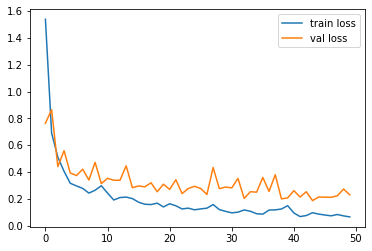

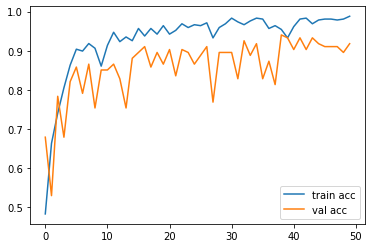

In [ ]:
plt.plot(fitted_model.history['loss'], label='train loss')
plt.plot(fitted_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(fitted_model.history['accuracy'], label='train acc')
plt.plot(fitted_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

In [26]:
# SAVING MODEL
from tensorflow.keras.models import load_model

model.save('malaria_vgg19.h5')

NameError: ignored

In [5]:
# LOADING MODEL

reloaded_model = tf.keras.models.load_model('malaria_vgg19.h5')
 
reloaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [42]:
# making single prediction

import numpy as np
from tensorflow.keras.preprocessing import image

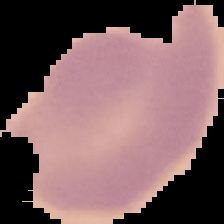

In [57]:
# testing the model for a normal cell image

test_image = image.load_img('/content/drive/MyDrive/Malaria Disease classification/data/Test/Uninfected/C3thin_original_IMG_20150608_163029_cell_80.png',
                            target_size=(224,224))
test_image

In [58]:
# converting image to array

test_image_arr = image.img_to_array(test_image)

test_image_arr

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [59]:
# normalizing every pixel between 0&1

test_image_arr = test_image_arr/255
test_image_arr

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [60]:
# the shape of test image is 64x64x3
# we need to make only single image prediction
# so we have to reshape to 1x64x64x3

print(f'Test image shape: {test_image_arr.shape}')

test_image_arr = np.expand_dims(test_image_arr, axis=0)

print(f'Test image reshaped: {test_image_arr.shape}')

Test image shape: (224, 224, 3)
Test image reshaped: (1, 224, 224, 3)


In [61]:
prediction = reloaded_model.predict(test_image_arr)

prediction

array([[0.05649832, 0.94350165]], dtype=float32)

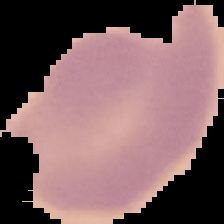

In [62]:
# re-checking the input image
test_image

In [63]:
# obtaining the model's prediction
a=np.argmax(prediction, axis=1)

if(a==1):
    print("This is a normal cell")
else:
    print("This is an infected cell")

This is a normal cell


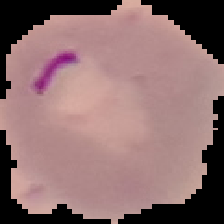

In [64]:
# testing the model for an infected image
test_image_infect = image.load_img('/content/drive/MyDrive/Malaria Disease classification/data/Test/Parasite/C39P4thinF_original_IMG_20150622_105554_cell_21.png',
                            target_size=(224,224))
test_image_infect

In [65]:
# converting image to array

test_image_infect_arr = image.img_to_array(test_image_infect)

In [66]:
# normalizing every pixel between 0&1

test_image_infect_arr = test_image_infect_arr/255

In [67]:
# the shape of test image is 64x64x3
# we need to make only single image prediction
# so we have to reshape to 1x64x64x3

print(f'Test image shape: {test_image_infect_arr.shape}')

test_image_infect_arr = np.expand_dims(test_image_infect_arr, axis=0)

print(f'Test image reshaped: {test_image_infect_arr.shape}')

Test image shape: (224, 224, 3)
Test image reshaped: (1, 224, 224, 3)


In [68]:
prediction = reloaded_model.predict(test_image_infect_arr)

prediction

array([[0.99568874, 0.00431126]], dtype=float32)

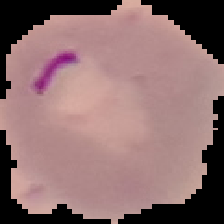

In [69]:
# re-checking the input image
test_image_infect

In [70]:
# obtaining the model's prediction
a=np.argmax(prediction, axis=1)

if(a==1):
    print("This is a normal cell")
else:
    print("This is an infected cell")

This is an infected cell
